In [1]:
import os
import sys
import json
from datetime import datetime

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

## Load Traffic Environment

In [2]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym_rev2 as env_gym

# Load the TensorBoard extension
%reload_ext tensorboard

## Create Test Function

In [3]:
def format_state(state):
    """
    Formats the state array so that specific indices are integers, 
    and others are rounded to one decimal place.
    """
    formatted_state = []
    for i, value in enumerate(state):
        if i in [1, 8, 15]:  # Indices to be converted to integers
            formatted_state.append(int(value))
        else:
            formatted_state.append(round(value, 1))  # Round to one decimal place
    return formatted_state

In [4]:
def test_model(model, env, num_episodes, output_file=None):
    """
    Evaluates the model over a specified number of episodes, records rewards for each episode,
    and plots the rewards.

    Args:
    - model: Trained model to be tested.
    - env (gym.Env): The environment to evaluate the model on.
    - num_episodes (int): Total number of episodes to run the evaluation.
    - output_file (str, optional): The path to the JSON file where episode details will be saved. If not provided,
      a timestamped default filename will be used.

    Returns:
    - episode_rewards (list): List of total rewards for each episode.
    """
    
    # Use a timestamped default filename if output_file is not provided
    if output_file is None:
        output_file = f"test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    # Initialize lists for rewards and timesteps
    rewards = []
    timesteps = []

    # Create a JSON file for writing
    with open(output_file, 'w') as f:
        # Run the model for the specified number of episodes
        for episode in range(num_episodes):
            obs, info = env.reset()
            episode_reward = 0
            episode_timestep = 0
            episode_details = {
                "Episode": episode + 1,
                "Initial State": format_state(obs.tolist() if hasattr(obs, 'tolist') else obs),
                "Timesteps": []
            }

            while True:  # Run until the episode ends
                action, _states = model.predict(obs, deterministic=True)
                action = int(action)
                mapped_action = action - 1
                obs, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                episode_timestep += 1

                # Log details of each timestep including reward
                timestep_details = {
                    "Timestep": episode_timestep,
                    "State": format_state(obs.tolist() if hasattr(obs, 'tolist') else obs),
                    "Action": mapped_action,
                    "Reward": reward
                }
                episode_details["Timesteps"].append(timestep_details)

                # Check if the episode is done
                if terminated or truncated:
                    episode_reward = round(episode_reward)
                    rewards.append(episode_reward)
                    timesteps.append(episode_timestep)

                    # Add total reward and timestep count to episode details
                    episode_details["Total Reward"] = episode_reward
                    episode_details["Total Timesteps"] = episode_timestep

                    # Write the full episode details as a JSON object to the file
                    f.write(json.dumps(episode_details) + "\n")
                    break  

    # Calculate average reward
    reward_ave = round(sum(rewards) / num_episodes)
    print(f"Average reward of {num_episodes} episodes is {reward_ave}.")

    # Calculate average timestep
    timestep_ave = round(sum(timesteps) / num_episodes)
    print(f"Average timesteps of {num_episodes} episodes is {timestep_ave}.")
    
    return rewards, timesteps

In [5]:
def plot_test_results(rewards, timesteps, interval=10):
    """
    Plots individual episode rewards and timesteps as dots with transparency, 
    along with average rewards and timesteps per specified interval (e.g., 10 episodes) as lines.

    Args:
    - rewards (list): List of total rewards for each episode.
    - timesteps (list): List of total timesteps for each episode.
    - interval (int): Number of episodes over which to average values for the line plot.
    """
    
    # Calculate average rewards and timesteps per interval episodes
    avg_rewards = [
        sum(rewards[i:i+interval]) / interval for i in range(0, len(rewards), interval)
    ]
    avg_timesteps = [
        sum(timesteps[i:i+interval]) / interval for i in range(0, len(timesteps), interval)
    ]
    
    # x-axis for average values positioned at the midpoint of each interval
    avg_episodes = [i + interval // 2 for i in range(0, len(rewards), interval)]

    # Set up a figure with two subplots: one for rewards and one for timesteps (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot rewards
    ax1.scatter(range(1, len(rewards) + 1), rewards, color='blue', alpha=0.3, label='Individual Episode Rewards')
    ax1.plot(avg_episodes, avg_rewards, color='red', marker='o', linestyle='-', linewidth=2, label=f'Average Reward per {interval} Episodes')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Rewards')
    ax1.legend()

    # Plot timesteps
    ax2.scatter(range(1, len(timesteps) + 1), timesteps, color='green', alpha=0.3, label='Individual Episode Timesteps')
    ax2.plot(avg_episodes, avg_timesteps, color='purple', marker='o', linestyle='-', linewidth=2, label=f'Average Timesteps per {interval} Episodes')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Timesteps')
    ax2.set_title(f'Timesteps')
    ax2.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## Baseline PPO Model

### Train Baseline Model

In [7]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
check_env(env, warn=True)
eval_env = Monitor(env_gym.TrafficEnvironment())

# Set up log directory
log_dir = "./logs/ppo_baseline_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env, 
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_baseline_model/PPO_1
Eval num_timesteps=1000, episode_reward=-17660.00 +/- 22736.04
Episode length: 1444.00 +/- 1515.74
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.44e+03  |
|    mean_reward     | -1.77e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-18536.00 +/- 19151.05
Episode length: 1502.40 +/- 1276.74
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.5e+03   |
|    mean_reward     | -1.85e+04 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 634       |
|    ep_rew_mean     | -4.51e+03 |
| time/      

In [10]:
# Start TensorBoard to monitor logs
%tensorboard --logdir ./logs/ppo_baseline_model/ --port=5002

### Test the Best Baseline Model

Average reward of 10000 episodes is -6592.
Average timesteps of 10000 episodes is 1059.


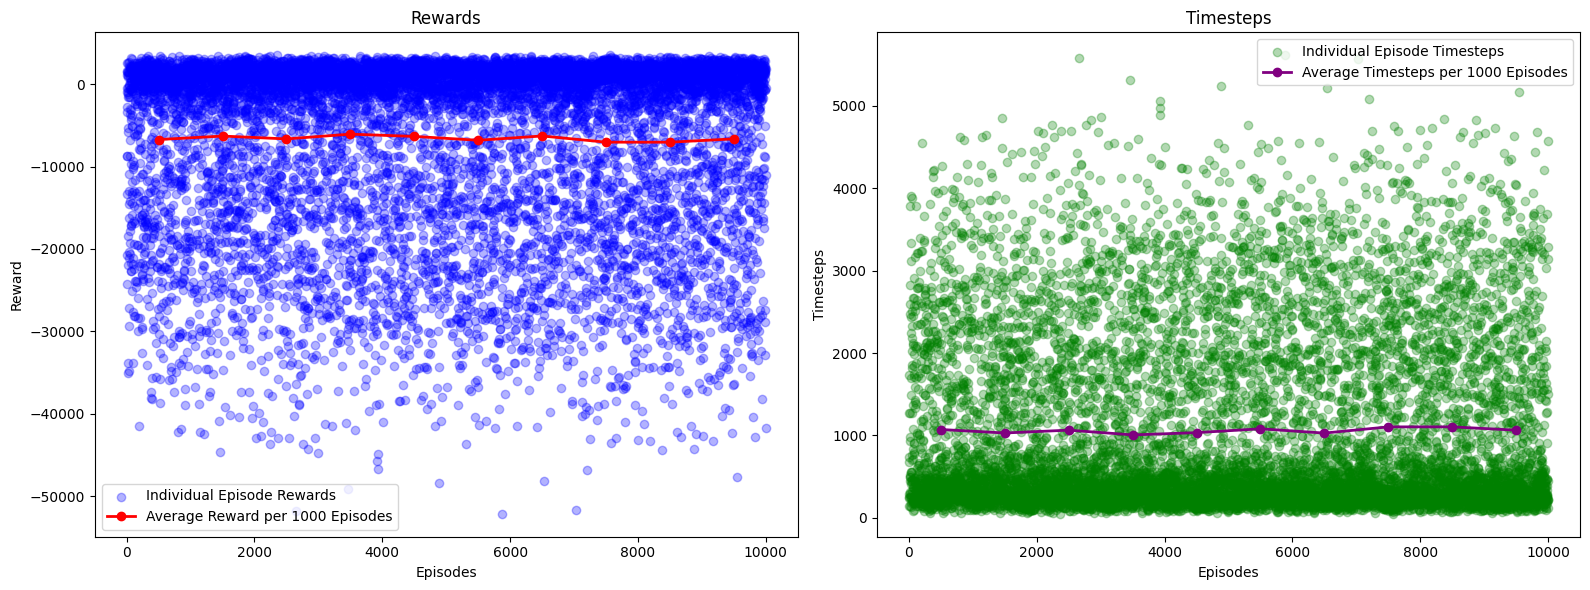

In [11]:
# Load the best baseline model
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()
check_env(env_test)

# Test the model
num_episodes = 10000
file_name = 'ppo_baseline_best_model_test_log.json'
rewards, timesteps = test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)
plot_test_results(rewards=rewards, timesteps=timesteps, interval=1000)

### Analysis of Test Results

In [12]:
# log_file = 'ppo_baseline_best_model_test_log.json'
def calculate_action_percentages(log_file):
    data = []
    
    # Load the JSON file
    with open(log_file, 'r') as f:
        for line in f:
            # Parse each line as a JSON object and add it to the list
            data.append(json.loads(line))
    
    # Initialize counters for each action
    action_counts = {-1: 0, 0: 0, 1: 0}
    total_actions = 0
    total_num_of_episodes = len(data)  # Count the total number of episodes

    # Iterate over all episodes and timesteps
    for episode in data:
        for timestep in episode["Timesteps"]:
            action = timestep["Action"]
            if action in action_counts:
                action_counts[action] += 1
            total_actions += 1

    # Calculate the percentage of each action
    action_percentages = {action: (count / total_actions) * 100 for action, count in action_counts.items()}

    # Print the results
    print(f"Total actions across {total_num_of_episodes} episodes: {total_actions}")
    for action, percentage in action_percentages.items():
        print(f"Action {action}: {percentage:.1f}%")

In [15]:
def calculate_clearance_rate_percentages(log_file):
    # Load the JSON file
    with open(log_file, 'r') as f:
        data = [json.loads(line) for line in f]  # Load each line as a JSON object

    # Initialize counters
    lane_counts_less_than_5 = [0] * 5  # Counts for clearance rate < 5 for each lane
    lane_counts_less_than_10 = [0] * 5  # Counts for clearance rate < 10 for each lane
    total_timesteps = 0  # Total number of timesteps across all episodes
    num_of_episodes = len(data)  # Count the total number of episodes

    # Iterate over all episodes
    for episode in data:
        # Include clearance rates from the initial state
        initial_clearance_rates = episode["Initial State"][-5:]
        total_timesteps += 1  # Count the initial state as a timestep

        for i, rate in enumerate(initial_clearance_rates):
            if rate < 5:
                lane_counts_less_than_5[i] += 1
            if rate < 10:
                lane_counts_less_than_10[i] += 1

        # Iterate over each timestep in the episode
        for timestep in episode["Timesteps"]:
            # Extract the last 5 values in "State" as clearance rates for the 5 lanes
            clearance_rates = timestep["State"][-5:]
            total_timesteps += 1

            # Count occurrences where clearance rate < 5 and < 10 for each lane
            for i, rate in enumerate(clearance_rates):
                if rate < 5:
                    lane_counts_less_than_5[i] += 1
                if rate < 10:
                    lane_counts_less_than_10[i] += 1

    # Calculate percentages for each lane
    lane_percentages_less_than_5 = [(count / total_timesteps) * 100 for count in lane_counts_less_than_5]
    lane_percentages_less_than_10 = [(count / total_timesteps) * 100 for count in lane_counts_less_than_10]

    # Print the results
    print(f"Total timesteps across {num_of_episodes} episodes (including initial states): {total_timesteps}")
    for i in range(5):
        print(f"Lane {i + 1}:")
        print(f"  {lane_percentages_less_than_5[i]:.1f}% of timesteps had a clearance rate less than 5")
        print(f"  {lane_percentages_less_than_10[i]:.1f}% of timesteps had a clearance rate less than 10")

In [22]:
def plot_clearance_rate_boxplots(log_file):
    # Initialize lists to hold clearance rates for each lane
    clearance_rates = [[] for _ in range(5)]  # One list per lane

    # Load the JSON file
    with open(log_file, 'r') as f:
        data = [json.loads(line) for line in f]  # Load each line as a JSON object

    # Iterate over all episodes
    for episode in data:
        # Include clearance rates from the initial state
        initial_clearance_rates = episode["Initial State"][-5:]
        for i, rate in enumerate(initial_clearance_rates):
            clearance_rates[i].append(rate)

        # Iterate over each timestep in the episode
        for timestep in episode["Timesteps"]:
            # Extract the last 5 values in "State" as clearance rates for the 5 lanes
            timestep_clearance_rates = timestep["State"][-5:]
            for i, rate in enumerate(timestep_clearance_rates):
                clearance_rates[i].append(rate)

    # Create subplots for side-by-side box plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the box plot with outliers
    axs[0].boxplot(clearance_rates, tick_labels=[f'Lane {i+1}' for i in range(5)])
    axs[0].set_title("Clearance Rate Distribution Across 5 Lanes (With Outliers)")
    axs[0].set_xlabel("Lane")
    axs[0].set_ylabel("Clearance Rate")

    # Plot the box plot without outliers
    axs[1].boxplot(clearance_rates, tick_labels=[f'Lane {i+1}' for i in range(5)], showfliers=False)
    axs[1].set_title("Clearance Rate Distribution Across 5 Lanes (Without Outliers)")
    axs[1].set_xlabel("Lane")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [26]:
# Load the json file
log_file = 'ppo_baseline_best_model_test_log.json'

In [13]:
calculate_action_percentages(log_file)

Total actions across 10000 episodes: 10591751
Action -1: 0.0%
Action 0: 100.0%
Action 1: 0.0%


In [16]:
calculate_clearance_rate_percentages(log_file)

Total timesteps across 10000 episodes (including initial states): 10601751
Lane 1:
  77.7% of timesteps had a clearance rate less than 5
  88.2% of timesteps had a clearance rate less than 10
Lane 2:
  77.2% of timesteps had a clearance rate less than 5
  87.9% of timesteps had a clearance rate less than 10
Lane 3:
  77.0% of timesteps had a clearance rate less than 5
  87.6% of timesteps had a clearance rate less than 10
Lane 4:
  77.1% of timesteps had a clearance rate less than 5
  87.4% of timesteps had a clearance rate less than 10
Lane 5:
  77.4% of timesteps had a clearance rate less than 5
  87.3% of timesteps had a clearance rate less than 10


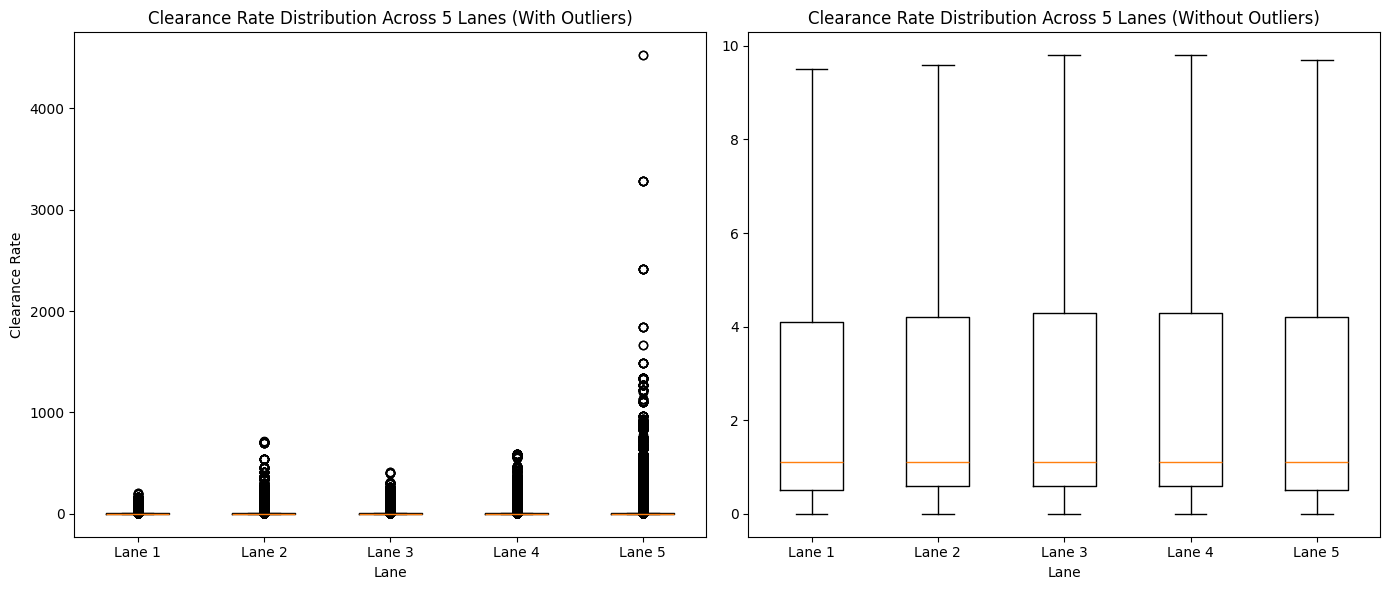

In [27]:
plot_clearance_rate_boxplots(log_file)